# BPSK Modem: End-to-End Digital Communications

This notebook implements a complete Binary Phase Shift Keying (BPSK) modem, demonstrating the full signal processing chain from bits to RF and back. We'll build each stage of the system, introduce realistic channel impairments, and show how the receiver recovers the original data.

## System Architecture

```
┌─────────────────────────────────────────────────────────────────────────────┐
│ TRANSMITTER                                                                 │
│  Bits → Symbol Mapping → Pulse Shaping → Upconversion → TX Signal          │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓
┌─────────────────────────────────────────────────────────────────────────────┐
│ CHANNEL                                                                     │
│  + AWGN + Frequency Offset + Phase Offset                                   │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓
┌─────────────────────────────────────────────────────────────────────────────┐
│ RECEIVER                                                                    │
│  RX Signal → Downconversion → Matched Filter → Carrier Sync → Decision     │
└─────────────────────────────────────────────────────────────────────────────┘
```

**BPSK Modulation:** Each bit is mapped to a symbol: `0 → -1`, `1 → +1`. The phase of the carrier encodes the data: 0° for `+1`, 180° for `-1`.

**Why BPSK?** It's the simplest coherent modulation scheme, provides excellent noise immunity (1 bit/symbol means maximum distance between constellation points), and forms the foundation for understanding more complex schemes like QPSK and QAM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

np.random.seed(42)  # Reproducible results

In [2]:
# System parameters
num_bits = 2000           # Number of bits to transmit
samples_per_symbol = 8    # Oversampling factor
fs = 80000                # Sample rate (Hz)
symbol_rate = fs / samples_per_symbol  # 10,000 symbols/sec
carrier_freq = 20000      # Carrier frequency (Hz)
alpha = 0.35              # RRC roll-off factor

print(f"Symbol rate: {symbol_rate:.0f} symbols/sec")
print(f"Carrier frequency: {carrier_freq} Hz")
print(f"Samples per symbol: {samples_per_symbol}")
print(f"Signal bandwidth: ±{symbol_rate * (1 + alpha) / 2:.0f} Hz around carrier")

Symbol rate: 10000 symbols/sec
Carrier frequency: 20000 Hz
Samples per symbol: 8
Signal bandwidth: ±6750 Hz around carrier


In [3]:
def compute_psd(sig, fs, nperseg=256):
    """
    Compute power spectral density using Welch's method.
    Returns frequencies and PSD in dB.
    """
    f, psd = signal.welch(sig, fs=fs, nperseg=nperseg, return_onesided=False)
    # Shift to center DC
    f = np.fft.fftshift(f)
    psd = np.fft.fftshift(psd)
    psd_db = 10 * np.log10(psd + 1e-12)
    return f, psd_db

---
## 1. Transmitter

### 1.1 Bit Generation and Symbol Mapping

We generate random bits and map them to BPSK symbols:

$$s[n] = 2 \cdot b[n] - 1$$

where $b[n] \in \{0, 1\}$ and $s[n] \in \{-1, +1\}$.

In [4]:
def generate_bits(num_bits):
    """Generate random binary data."""
    return np.random.randint(0, 2, num_bits)

def bits_to_bpsk_symbols(bits):
    """Map bits to BPSK symbols: 0 → -1, 1 → +1."""
    return 2.0 * bits - 1.0

# Generate data
tx_bits = generate_bits(num_bits)
tx_symbols = bits_to_bpsk_symbols(tx_bits)

print(f"First 20 bits:    {tx_bits[:20]}")
print(f"First 20 symbols: {tx_symbols[:20].astype(int)}")

First 20 bits:    [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0]
First 20 symbols: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1  1 -1]


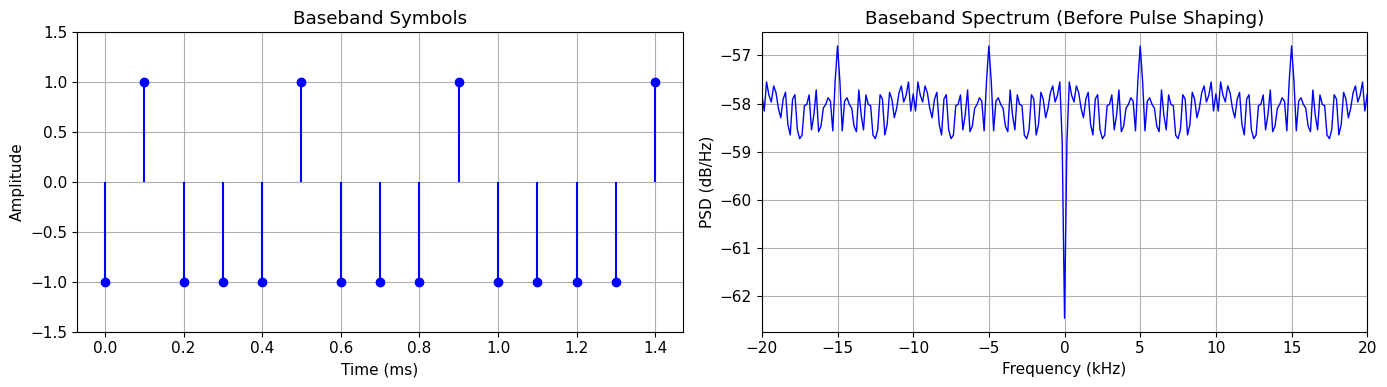

Note: Impulse train has wide bandwidth with periodic structure at symbol rate


In [5]:
# Create upsampled symbol stream (impulses at symbol rate)
symbol_impulses = np.zeros(len(tx_symbols) * samples_per_symbol)
symbol_impulses[::samples_per_symbol] = tx_symbols

# Visualize baseband symbols (before pulse shaping)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time domain - first 15 symbols
num_show = 15
t_show_sym = np.arange(num_show) / symbol_rate * 1000  # Time at symbol centers
axes[0].stem(t_show_sym, tx_symbols[:num_show], basefmt=' ', linefmt='b-', markerfmt='bo')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Baseband Symbols')
axes[0].set_ylim(-1.5, 1.5)

# Frequency domain - PSD of symbol impulse train
f, psd_db = compute_psd(symbol_impulses, fs, nperseg=512)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Baseband Spectrum (Before Pulse Shaping)')
axes[1].set_xlim(-20, 20)

plt.tight_layout()
plt.show()

print("Note: Impulse train has wide bandwidth with periodic structure at symbol rate")

### 1.2 Pulse Shaping with Root Raised Cosine Filter

Raw symbols are impulses — transmitting them directly would require excessive bandwidth. We apply a **root raised cosine (RRC) filter** to limit bandwidth while maintaining zero inter-symbol interference (ISI) at optimal sampling instants.

Using RRC at both TX and RX gives: $\text{RRC}_{TX} * \text{RRC}_{RX} = \text{Raised Cosine}$ (zero ISI)

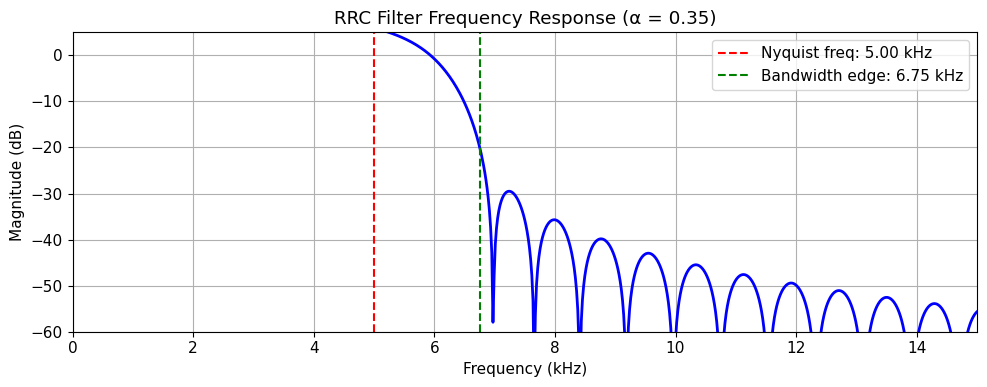

In [6]:
def design_rrc_filter(samples_per_symbol, num_taps, alpha):
    """
    Design a root-raised cosine (RRC) filter.
    """
    T = samples_per_symbol
    t = np.arange(num_taps) - (num_taps - 1) / 2
    h = np.zeros(num_taps)
    
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = (1 + alpha * (4/np.pi - 1))
        elif alpha > 0 and abs(abs(ti) - T / (4 * alpha)) < 1e-8:
            h[i] = (alpha / np.sqrt(2)) * (
                (1 + 2/np.pi) * np.sin(np.pi / (4*alpha)) +
                (1 - 2/np.pi) * np.cos(np.pi / (4*alpha))
            )
        else:
            num = np.sin(np.pi * ti / T * (1 - alpha)) + \
                  4 * alpha * ti / T * np.cos(np.pi * ti / T * (1 + alpha))
            den = np.pi * ti / T * (1 - (4 * alpha * ti / T)**2)
            if abs(den) > 1e-10:
                h[i] = num / den
    
    h /= np.sqrt(np.sum(h**2))
    return h

# Design filter
num_taps = 101
rrc_filter = design_rrc_filter(samples_per_symbol, num_taps, alpha)

# Visualize filter frequency response
fig, ax = plt.subplots(figsize=(10, 4))

w, H = signal.freqz(rrc_filter, worN=2048, fs=fs)
ax.plot(w/1000, 20*np.log10(np.abs(H) + 1e-12), 'b-', linewidth=2)
ax.axvline(x=symbol_rate/2/1000, color='r', linestyle='--', 
           label=f'Nyquist freq: {symbol_rate/2/1000:.2f} kHz')
ax.axvline(x=symbol_rate/2*(1+alpha)/1000, color='g', linestyle='--', 
           label=f'Bandwidth edge: {symbol_rate/2*(1+alpha)/1000:.2f} kHz')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title(f'RRC Filter Frequency Response (α = {alpha})')
ax.set_xlim(0, 15)
ax.set_ylim(-60, 5)
ax.legend()

plt.tight_layout()
plt.show()

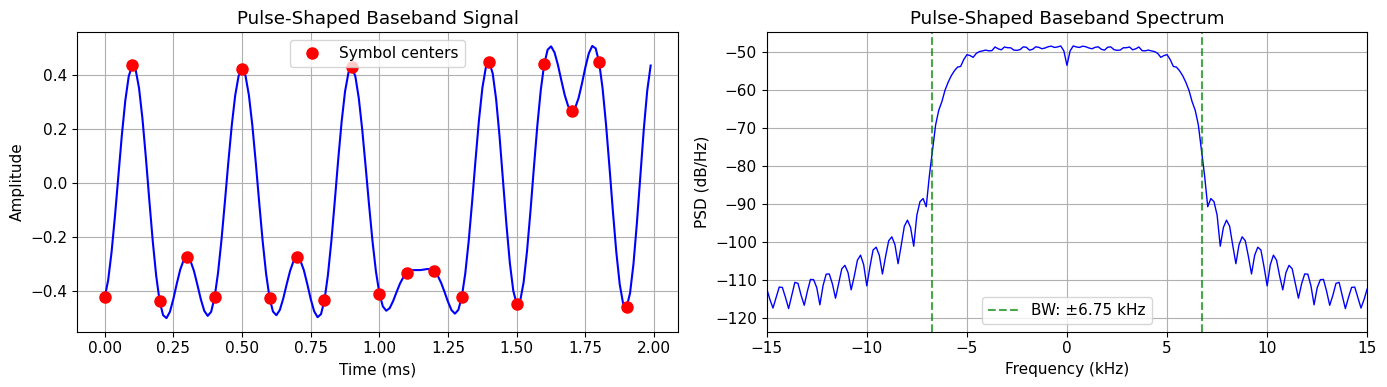

Spectrum is now band-limited by the RRC filter


In [7]:
def upsample_and_filter(symbols, samples_per_symbol, filt):
    """Upsample symbols and apply pulse shaping filter."""
    upsampled = np.zeros(len(symbols) * samples_per_symbol)
    upsampled[::samples_per_symbol] = symbols
    baseband = np.convolve(upsampled, filt, mode='same')
    return baseband

# Generate pulse-shaped baseband signal
tx_baseband = upsample_and_filter(tx_symbols, samples_per_symbol, rrc_filter)

# Visualize pulse-shaped baseband
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time domain
num_show = 20
sample_indices = np.arange(num_show * samples_per_symbol)
t_show = sample_indices / fs * 1000
axes[0].plot(t_show, tx_baseband[:num_show * samples_per_symbol], 'b-', linewidth=1.5)
# Mark symbol centers
symbol_centers = np.arange(num_show) * samples_per_symbol
axes[0].plot(symbol_centers / fs * 1000, tx_baseband[symbol_centers], 'ro', 
             markersize=8, label='Symbol centers')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Pulse-Shaped Baseband Signal')
axes[0].legend()

# Frequency domain
f, psd_db = compute_psd(tx_baseband, fs, nperseg=512)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].axvline(x=symbol_rate/2*(1+alpha)/1000, color='g', linestyle='--', alpha=0.7,
               label=f'BW: ±{symbol_rate/2*(1+alpha)/1000:.2f} kHz')
axes[1].axvline(x=-symbol_rate/2*(1+alpha)/1000, color='g', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Pulse-Shaped Baseband Spectrum')
axes[1].set_xlim(-15, 15)
axes[1].legend()

plt.tight_layout()
plt.show()

print("Spectrum is now band-limited by the RRC filter")

### 1.3 Carrier Modulation (Upconversion)

The baseband signal is modulated onto a carrier frequency $f_c$:

$$x_{RF}(t) = x_{BB}(t) \cdot \cos(2\pi f_c t)$$

For BPSK with real baseband, this produces a double-sideband signal centered at $f_c$.

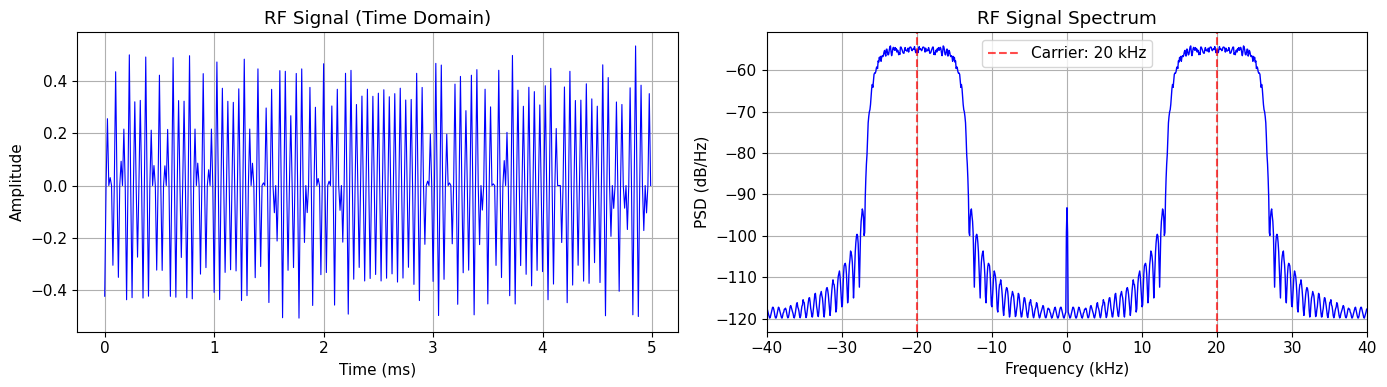

In [8]:
def upconvert(baseband, carrier_freq, fs):
    """Modulate baseband signal onto carrier."""
    t = np.arange(len(baseband)) / fs
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    rf_signal = baseband * carrier
    return rf_signal

# Upconvert to carrier
tx_rf = upconvert(tx_baseband, carrier_freq, fs)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time domain (zoomed to see carrier)
t_zoom = np.arange(400) / fs * 1000
axes[0].plot(t_zoom, tx_rf[:400], 'b-', linewidth=0.8)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('RF Signal (Time Domain)')

# Spectrum
f, psd_db = compute_psd(tx_rf, fs, nperseg=1024)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].axvline(x=carrier_freq/1000, color='r', linestyle='--', alpha=0.7,
               label=f'Carrier: {carrier_freq/1000:.0f} kHz')
axes[1].axvline(x=-carrier_freq/1000, color='r', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('RF Signal Spectrum')
axes[1].set_xlim(-40, 40)
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 2. Channel Model

Real channels introduce impairments:

1. **AWGN (Additive White Gaussian Noise):** Thermal noise, quantified by SNR
2. **Frequency offset:** Doppler shift or LO mismatch between TX and RX
3. **Phase offset:** Unknown initial phase relationship

These are the exact impairments you'll face with unsynchronized SDRs.

In [9]:
def add_awgn(sig, snr_db):
    """Add white Gaussian noise to achieve target SNR."""
    sig_power = np.mean(np.abs(sig)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = sig_power / snr_linear
    if np.iscomplexobj(sig):
        noise = np.sqrt(noise_power/2) * (np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))
    else:
        noise = np.sqrt(noise_power) * np.random.randn(len(sig))
    return sig + noise

# Channel parameters
snr_db = 15              # Signal-to-noise ratio
freq_offset_hz = 50      # 50 Hz frequency offset (LO mismatch)
phase_offset_rad = 1.2   # ~69 degrees initial phase offset

# Apply AWGN to RF signal
rx_rf = add_awgn(tx_rf, snr_db)

print(f"Channel parameters:")
print(f"  SNR: {snr_db} dB")
print(f"  Frequency offset: {freq_offset_hz} Hz")
print(f"  Phase offset: {np.degrees(phase_offset_rad):.1f}°")

Channel parameters:
  SNR: 15 dB
  Frequency offset: 50 Hz
  Phase offset: 68.8°


---
## 3. Receiver

### 3.1 Downconversion to Complex Baseband

We mix the received RF signal with a local oscillator at the carrier frequency to extract the complex baseband signal. The receiver's LO may have a frequency offset $\Delta f$ relative to the transmitter:

$$x_{BB}(t) = \text{LPF}\left\{x_{RF}(t) \cdot e^{-j2\pi (f_c + \Delta f) t}\right\}$$

In [10]:
def downconvert(rf_signal, carrier_freq, fs, lpf_cutoff, freq_offset=0, phase_offset=0):
    """
    Downconvert RF signal to complex baseband.
    
    Parameters
    ----------
    rf_signal : Real-valued RF signal
    carrier_freq : Nominal carrier frequency (Hz)
    fs : Sample rate (Hz)
    lpf_cutoff : Lowpass filter cutoff (Hz)
    freq_offset : Frequency offset between TX and RX LOs (Hz)
    phase_offset : Phase offset (radians)
    """
    t = np.arange(len(rf_signal)) / fs
    
    # Receiver LO - if there's a freq offset, the RX LO is at carrier_freq,
    # but the TX was actually at carrier_freq + freq_offset
    # So after mixing, we get a residual tone at freq_offset
    lo = np.exp(-1j * (2 * np.pi * carrier_freq * t + phase_offset))
    
    # Mix down to baseband
    mixed = rf_signal * lo
    
    # Lowpass filter to remove 2*fc component
    nyquist = fs / 2
    lpf = signal.firwin(65, lpf_cutoff / nyquist)
    baseband = signal.lfilter(lpf, 1, mixed)
    
    # Apply frequency offset (simulates LO mismatch)
    if freq_offset != 0:
        baseband = baseband * np.exp(1j * 2 * np.pi * freq_offset * t)
    
    return baseband

# Downconvert with frequency and phase offset
lpf_cutoff = symbol_rate * (1 + alpha) * 0.7
rx_baseband_raw = downconvert(rx_rf, carrier_freq, fs, lpf_cutoff, 
                               freq_offset=freq_offset_hz, 
                               phase_offset=phase_offset_rad)

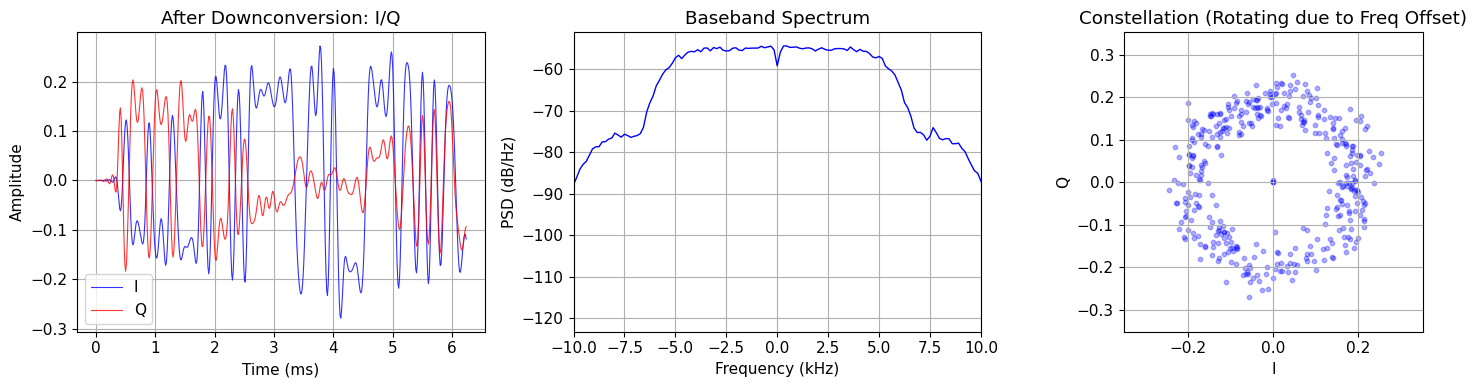

Frequency offset causes constellation to rotate over time → appears as ring


In [11]:
# Visualize received baseband after downconversion
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time domain I/Q
t_show = np.arange(500) / fs * 1000
axes[0].plot(t_show, rx_baseband_raw[:500].real, 'b-', label='I', alpha=0.8, linewidth=0.8)
axes[0].plot(t_show, rx_baseband_raw[:500].imag, 'r-', label='Q', alpha=0.8, linewidth=0.8)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('After Downconversion: I/Q')
axes[0].legend()

# Frequency domain
f, psd_db = compute_psd(rx_baseband_raw, fs, nperseg=512)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Baseband Spectrum')
axes[1].set_xlim(-10, 10)

# Constellation (rotating ring due to freq offset)
skip = samples_per_symbol
axes[2].scatter(rx_baseband_raw[::skip].real[:400], 
                rx_baseband_raw[::skip].imag[:400], 
                alpha=0.3, s=10, c='blue')
axes[2].set_xlabel('I')
axes[2].set_ylabel('Q')
axes[2].set_title('Constellation (Rotating due to Freq Offset)')
axes[2].set_aspect('equal')
max_val = np.percentile(np.abs(rx_baseband_raw), 98) * 1.3
axes[2].set_xlim(-max_val, max_val)
axes[2].set_ylim(-max_val, max_val)

plt.tight_layout()
plt.show()

print("Frequency offset causes constellation to rotate over time → appears as ring")

### 3.2 Matched Filtering

The matched filter maximizes SNR at the sampling instant. For RRC pulse shaping at TX, we apply the same RRC filter at RX:

$$\text{RRC}_{TX} * \text{RRC}_{RX} = \text{Raised Cosine (zero ISI)}$$

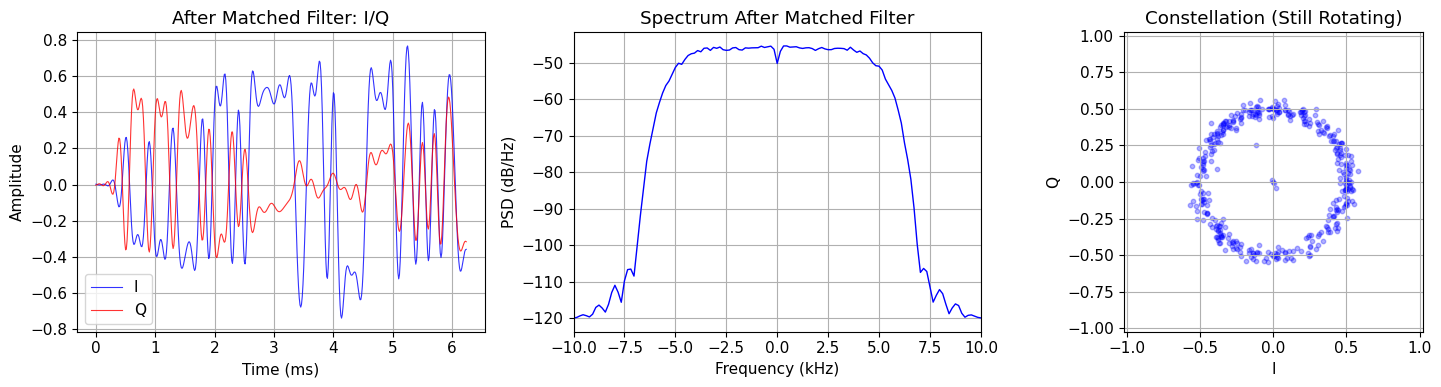

In [12]:
# Apply matched filter
rx_matched = np.convolve(rx_baseband_raw, rrc_filter, mode='same')

# Visualize after matched filter
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time domain
axes[0].plot(t_show, rx_matched[:500].real, 'b-', label='I', alpha=0.8, linewidth=0.8)
axes[0].plot(t_show, rx_matched[:500].imag, 'r-', label='Q', alpha=0.8, linewidth=0.8)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('After Matched Filter: I/Q')
axes[0].legend()

# Frequency domain
f, psd_db = compute_psd(rx_matched, fs, nperseg=512)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Spectrum After Matched Filter')
axes[1].set_xlim(-10, 10)

# Constellation (still rotating)
axes[2].scatter(rx_matched[::skip].real[:400], 
                rx_matched[::skip].imag[:400], 
                alpha=0.3, s=10, c='blue')
axes[2].set_xlabel('I')
axes[2].set_ylabel('Q')
axes[2].set_title('Constellation (Still Rotating)')
axes[2].set_aspect('equal')
max_val = np.percentile(np.abs(rx_matched), 98) * 1.3
axes[2].set_xlim(-max_val, max_val)
axes[2].set_ylim(-max_val, max_val)

plt.tight_layout()
plt.show()

### 3.3 Frequency Offset Estimation and Correction

For BPSK, we can use the **squaring method** to estimate frequency offset. Squaring removes the ±1 modulation:

$$x^2(t) = (\pm 1)^2 \cdot e^{j2(2\pi \Delta f \cdot t + \phi)} = e^{j4\pi \Delta f \cdot t + j2\phi}$$

The squared signal has a tone at $2\Delta f$, which we detect via FFT and divide by 2.

In [13]:
def estimate_freq_offset_squaring(sig, fs):
    """
    Estimate frequency offset using squaring method for BPSK.
    """
    # Square the signal to remove BPSK modulation
    squared = sig ** 2
    
    # FFT to find the tone at 2x frequency offset
    N = len(squared)
    spectrum = np.fft.fft(squared)
    freqs = np.fft.fftfreq(N, 1/fs)
    
    # Search in reasonable range (avoid DC, look for the peak)
    search_range = (np.abs(freqs) > 5) & (np.abs(freqs) < 500)
    search_spectrum = np.abs(spectrum) * search_range
    
    # Find peak
    peak_idx = np.argmax(search_spectrum)
    freq_estimate = freqs[peak_idx] / 2  # Divide by 2 (we squared)
    
    return freq_estimate

def correct_freq_offset(sig, freq_offset, fs):
    """Remove frequency offset by counter-rotation."""
    t = np.arange(len(sig)) / fs
    return sig * np.exp(-1j * 2 * np.pi * freq_offset * t)

# Estimate and correct frequency offset
est_freq_offset = estimate_freq_offset_squaring(rx_matched, fs)
rx_freq_corrected = correct_freq_offset(rx_matched, est_freq_offset, fs)

print(f"Estimated frequency offset: {est_freq_offset:.2f} Hz")
print(f"Actual frequency offset: {freq_offset_hz} Hz")
print(f"Estimation error: {abs(est_freq_offset - freq_offset_hz):.2f} Hz")

Estimated frequency offset: 50.00 Hz
Actual frequency offset: 50 Hz
Estimation error: 0.00 Hz


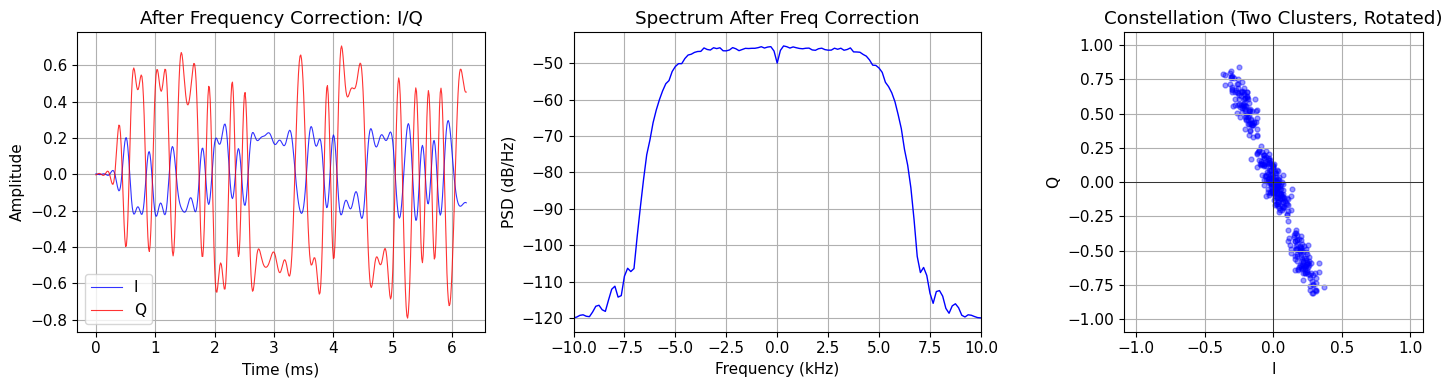

Constellation now shows two distinct clusters (not a ring)
Clusters are rotated away from I-axis by the phase offset


In [14]:
# Visualize after frequency correction
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time domain
axes[0].plot(t_show, rx_freq_corrected[:500].real, 'b-', label='I', alpha=0.8, linewidth=0.8)
axes[0].plot(t_show, rx_freq_corrected[:500].imag, 'r-', label='Q', alpha=0.8, linewidth=0.8)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('After Frequency Correction: I/Q')
axes[0].legend()

# Frequency domain
f, psd_db = compute_psd(rx_freq_corrected, fs, nperseg=512)
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Spectrum After Freq Correction')
axes[1].set_xlim(-10, 10)

# Constellation - sample at symbol centers
symbol_samples_fc = rx_freq_corrected[samples_per_symbol//2::samples_per_symbol]
axes[2].scatter(symbol_samples_fc.real[:400], symbol_samples_fc.imag[:400], 
                alpha=0.4, s=12, c='blue')
axes[2].set_xlabel('I')
axes[2].set_ylabel('Q')
axes[2].set_title('Constellation (Two Clusters, Rotated)')
axes[2].set_aspect('equal')
max_val = np.percentile(np.abs(symbol_samples_fc), 98) * 1.3
axes[2].set_xlim(-max_val, max_val)
axes[2].set_ylim(-max_val, max_val)
axes[2].axhline(y=0, color='k', linewidth=0.5)
axes[2].axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Constellation now shows two distinct clusters (not a ring)")
print("Clusters are rotated away from I-axis by the phase offset")

### 3.4 Timing Recovery (Mueller-Muller)

Without timing recovery, the receiver samples at a fixed offset within each symbol period. If this offset doesn't align with the true symbol centers — for example, due to filter group delay — inter-symbol interference (ISI) degrades performance even with perfect frequency and phase correction.

The **Mueller-Muller timing error detector (TED)** estimates the optimal sampling instant by comparing consecutive symbols and their decisions:

$$e[n] = \text{Re}\{x[n] \cdot \hat{a}^*[n-1] - x[n-1] \cdot \hat{a}^*[n]\}$$

where $x[n]$ is the interpolated sample and $\hat{a}[n]$ is the hard decision. A PI loop filter smooths the error and drives a linear interpolator to converge on the correct timing. The loop outputs symbol-rate samples at the recovered instants.

In [ ]:
def mueller_muller_timing_recovery(sig, sps, loop_bw=0.01):
    """
    Mueller-Muller timing recovery for BPSK.
    
    Recovers optimal symbol sampling instants using the M&M timing error
    detector with a PI loop filter and linear interpolation.
    
    Parameters
    ----------
    sig : complex array
        Oversampled signal (after matched filtering)
    sps : int
        Nominal samples per symbol
    loop_bw : float
        Normalized loop bandwidth (controls convergence vs jitter)
    
    Returns
    -------
    symbols : complex array - symbols at recovered timing instants
    errors : float array - timing error at each symbol
    mu_log : float array - fractional delay history
    """
    # PI loop filter gains (critically damped)
    damping = 1.0 / np.sqrt(2)
    Kp = 2 * damping * loop_bw
    Ki = loop_bw ** 2
    
    symbols_out = []
    errors_out = []
    mu_out = []
    
    mu = 0.0            # fractional sample offset
    integrator = 0.0    # loop filter state
    prev_sample = 0+0j
    prev_decision = 0+0j
    
    n = sps  # start one symbol period in
    while n < len(sig) - 1:
        # Interpolation index
        idx = int(np.floor(n + mu))
        frac = (n + mu) - idx
        if idx < 0 or idx + 1 >= len(sig):
            break
        
        # Linear interpolation at estimated symbol center
        sample = sig[idx] + frac * (sig[idx + 1] - sig[idx])
        
        # BPSK hard decision
        decision = complex(np.sign(sample.real), 0)
        
        # Mueller-Muller timing error detector
        error = np.real(sample * np.conj(prev_decision) -
                        prev_sample * np.conj(decision))
        
        # PI loop filter update
        integrator += Ki * error
        mu -= Kp * error + integrator
        
        symbols_out.append(sample)
        errors_out.append(error)
        mu_out.append(mu)
        
        prev_sample = sample
        prev_decision = decision
        n += sps
    
    return np.array(symbols_out), np.array(errors_out), np.array(mu_out)

# Apply timing recovery to frequency-corrected signal
rx_symbols_tr, timing_errors, mu_log = mueller_muller_timing_recovery(
    rx_freq_corrected, samples_per_symbol, loop_bw=0.01)

print(f"Recovered {len(rx_symbols_tr)} symbols via timing recovery")
print(f"Final fractional delay (μ): {mu_log[-1]:.3f} samples")

In [ ]:
# Visualize timing recovery diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Timing error convergence
axes[0].plot(timing_errors, 'b-', linewidth=0.5, alpha=0.6)
axes[0].set_xlabel('Symbol Index')
axes[0].set_ylabel('Timing Error')
axes[0].set_title('M&M Timing Error Convergence')

# Fractional delay trajectory
axes[1].plot(mu_log, 'b-', linewidth=1)
axes[1].set_xlabel('Symbol Index')
axes[1].set_ylabel('Fractional Delay (samples)')
axes[1].set_title('Interpolation Offset (μ)')

# Constellation (two clusters, rotated by residual phase offset)
axes[2].scatter(rx_symbols_tr.real[:400], rx_symbols_tr.imag[:400],
                alpha=0.4, s=12, c='blue')
axes[2].set_xlabel('I')
axes[2].set_ylabel('Q')
axes[2].set_title('Constellation (After Timing Recovery)')
axes[2].set_aspect('equal')
max_val = np.percentile(np.abs(rx_symbols_tr), 98) * 1.3
axes[2].set_xlim(-max_val, max_val)
axes[2].set_ylim(-max_val, max_val)
axes[2].axhline(y=0, color='k', linewidth=0.5)
axes[2].axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Timing error converges to zero as the loop locks")
print("Constellation now shows two tight clusters (rotated by residual phase offset)")

### 3.5 Phase Offset Estimation and Correction

After frequency correction, the residual phase offset rotates the constellation. For BPSK, we estimate this by squaring (to remove modulation) and finding the average phase.

In [ ]:
def estimate_phase_offset_bpsk(symbols):
    """
    Estimate residual phase offset for BPSK.
    
    Squaring removes the ±1 modulation, leaving a tone at 2θ.
    The average phase of the squared symbols gives 2θ, so divide by 2.
    """
    squared = symbols ** 2
    avg_squared = np.mean(squared)
    phase_estimate = np.angle(avg_squared) / 2
    return phase_estimate

def correct_phase_offset(sig, phase):
    """Remove phase offset by counter-rotation."""
    return sig * np.exp(-1j * phase)

# Estimate and correct phase on timing-recovered symbols
est_phase_offset = estimate_phase_offset_bpsk(rx_symbols_tr)
rx_corrected = correct_phase_offset(rx_symbols_tr, est_phase_offset)

print(f"Estimated phase offset: {np.degrees(est_phase_offset):.1f}°")
print(f"Actual phase offset: {np.degrees(phase_offset_rad):.1f}°")
print(f"Estimation error: {abs(np.degrees(est_phase_offset - phase_offset_rad)):.1f}°")

In [ ]:
# Visualize after phase correction (symbol-rate data from timing recovery)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Symbol I/Q values over time
num_show_sym = 50
t_sym = np.arange(num_show_sym) / symbol_rate * 1000
axes[0].stem(t_sym, rx_corrected[:num_show_sym].real, linefmt='b-', markerfmt='bo',
             basefmt=' ', label='I')
axes[0].stem(t_sym, rx_corrected[:num_show_sym].imag, linefmt='r-', markerfmt='ro',
             basefmt=' ', label='Q')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('After Phase Correction: Symbol I/Q')
axes[0].legend()

# PSD at symbol rate
f, psd_db = compute_psd(rx_corrected, symbol_rate, nperseg=min(256, len(rx_corrected)))
axes[1].plot(f/1000, psd_db, 'b-', linewidth=1)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('PSD (dB/Hz)')
axes[1].set_title('Symbol-Rate Spectrum')

# Final constellation
axes[2].scatter(rx_corrected.real[:400], rx_corrected.imag[:400],
                alpha=0.4, s=12, c='blue')
axes[2].set_xlabel('I')
axes[2].set_ylabel('Q')
axes[2].set_title('Final Constellation (Aligned to I-axis)')
axes[2].set_aspect('equal')
max_val = np.percentile(np.abs(rx_corrected), 98) * 1.3
axes[2].set_xlim(-max_val, max_val)
axes[2].set_ylim(-max_val, max_val)
axes[2].axhline(y=0, color='k', linewidth=0.5)
axes[2].axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Symbols now cluster at +I and -I (on real axis) — ready for detection")

### 3.6 Symbol Detection and Bit Recovery

For BPSK, detection is simple: check the sign of the real part.

$$\hat{b}[n] = \begin{cases} 1 & \text{Re}\{r[n]\} > 0 \\ 0 & \text{otherwise} \end{cases}$$

In [ ]:
def detect_bpsk(symbols):
    """BPSK detection: sign of real part."""
    return (symbols.real > 0).astype(int)

def calculate_ber(tx_bits, rx_bits):
    """Calculate bit error rate."""
    min_len = min(len(tx_bits), len(rx_bits))
    errors = np.sum(tx_bits[:min_len] != rx_bits[:min_len])
    return errors / min_len, errors, min_len

# Detect from phase-corrected, timing-recovered symbols (already at symbol rate)
rx_bits_raw = detect_bpsk(rx_corrected)

# Find alignment between TX and RX bits via cross-correlation
# (accounts for filter delay and timing recovery convergence)
corr_len = min(1000, len(rx_bits_raw), len(tx_bits))
correlation = np.correlate(rx_bits_raw[:corr_len] * 2 - 1,
                           tx_bits[:corr_len] * 2 - 1, mode='full')
delay = np.argmax(np.abs(correlation)) - (corr_len - 1)

print(f"Detected bit alignment delay: {delay} symbols")

# Align bits
if delay >= 0:
    rx_bits_aligned = rx_bits_raw[delay:]
    tx_bits_aligned = tx_bits
else:
    rx_bits_aligned = rx_bits_raw
    tx_bits_aligned = tx_bits[-delay:]

# Handle potential 180° phase ambiguity (BPSK can lock to inverted phase)
ber1, errors1, total1 = calculate_ber(tx_bits_aligned, rx_bits_aligned)
ber2, errors2, total2 = calculate_ber(tx_bits_aligned, 1 - rx_bits_aligned)  # Inverted

if ber2 < ber1:
    print("Note: 180° phase ambiguity detected — inverting bits")
    rx_bits_aligned = 1 - rx_bits_aligned
    ber, errors, total = ber2, errors2, total2
else:
    ber, errors, total = ber1, errors1, total1

print(f"\n=== Results ===")
print(f"Bits transmitted: {num_bits}")
print(f"Bits compared: {total}")
print(f"Bit errors: {errors}")
print(f"Bit Error Rate: {ber:.4e}")
print(f"SNR: {snr_db} dB")

---
## 4. Impact of Channel Impairments

Let's verify the receiver handles various impairment combinations.

In [ ]:
def run_bpsk_modem(snr_db, num_bits, samples_per_symbol, fs, carrier_freq,
                   rrc_filter, alpha, freq_offset_hz=0, phase_offset_rad=0):
    """
    Run complete BPSK modem simulation and return BER.
    """
    symbol_rate = fs / samples_per_symbol

    # === TRANSMITTER ===
    tx_bits = generate_bits(num_bits)
    tx_symbols = bits_to_bpsk_symbols(tx_bits)
    tx_baseband = upsample_and_filter(tx_symbols, samples_per_symbol, rrc_filter)
    tx_rf = upconvert(tx_baseband, carrier_freq, fs)

    # === CHANNEL ===
    rx_rf = add_awgn(tx_rf, snr_db)

    # === RECEIVER ===
    lpf_cutoff = symbol_rate * (1 + alpha) * 0.7
    rx_baseband = downconvert(rx_rf, carrier_freq, fs, lpf_cutoff,
                              freq_offset=freq_offset_hz,
                              phase_offset=phase_offset_rad)

    # Matched filter
    rx_matched = np.convolve(rx_baseband, rrc_filter, mode='same')

    # Frequency correction
    if freq_offset_hz != 0:
        est_freq = estimate_freq_offset_squaring(rx_matched, fs)
        rx_matched = correct_freq_offset(rx_matched, est_freq, fs)

    # Timing recovery (Mueller-Muller)
    rx_symbols, _, _ = mueller_muller_timing_recovery(rx_matched, samples_per_symbol)

    # Phase correction
    est_phase = estimate_phase_offset_bpsk(rx_symbols)
    rx_corrected = correct_phase_offset(rx_symbols, est_phase)

    # Detection (symbols already at symbol rate)
    rx_bits = detect_bpsk(rx_corrected)

    # Align bits
    corr_len = min(500, len(rx_bits), len(tx_bits))
    if corr_len < 10:
        return 0.5

    correlation = np.correlate(rx_bits[:corr_len] * 2 - 1,
                               tx_bits[:corr_len] * 2 - 1, mode='full')
    delay = np.argmax(np.abs(correlation)) - (corr_len - 1)

    if delay >= 0:
        rx_bits_aligned = rx_bits[delay:]
        tx_bits_aligned = tx_bits
    else:
        rx_bits_aligned = rx_bits
        tx_bits_aligned = tx_bits[-delay:]

    # Check both polarities (BPSK phase ambiguity)
    ber1, _, _ = calculate_ber(tx_bits_aligned, rx_bits_aligned)
    ber2, _, _ = calculate_ber(tx_bits_aligned, 1 - rx_bits_aligned)

    return min(ber1, ber2)

# Test with various impairments
test_snr = 12  # dB

print(f"Testing at SNR = {test_snr} dB with various impairments:\n")

test_cases = [
    {"freq_offset_hz": 0, "phase_offset_rad": 0, "name": "No impairments"},
    {"freq_offset_hz": 0, "phase_offset_rad": np.pi/3, "name": "Phase only (60°)"},
    {"freq_offset_hz": 50, "phase_offset_rad": 0, "name": "Freq only (50 Hz)"},
    {"freq_offset_hz": 50, "phase_offset_rad": np.pi/3, "name": "Both (50 Hz, 60°)"},
    {"freq_offset_hz": 100, "phase_offset_rad": np.pi/2, "name": "Severe (100 Hz, 90°)"},
]

for case in test_cases:
    bers = []
    for _ in range(5):
        ber = run_bpsk_modem(
            snr_db=test_snr,
            num_bits=5000,
            samples_per_symbol=samples_per_symbol,
            fs=fs,
            carrier_freq=carrier_freq,
            rrc_filter=rrc_filter,
            alpha=alpha,
            freq_offset_hz=case["freq_offset_hz"],
            phase_offset_rad=case["phase_offset_rad"]
        )
        bers.append(ber)
    avg_ber = np.mean(bers)
    print(f"  {case['name']:25s} → BER = {avg_ber:.2e}")

# Theoretical BER for reference
def theoretical_bpsk_ber(snr_db):
    snr_linear = 10**(snr_db / 10)
    return 0.5 * erfc(np.sqrt(snr_linear))

print(f"\n  Theoretical BPSK BER:    → BER = {theoretical_bpsk_ber(test_snr):.2e}")

---
## Summary

This notebook implemented a complete BPSK modem demonstrating:

| Stage | Key DSP Concepts |
|-------|------------------|
| **TX: Symbol Mapping** | Binary to bipolar conversion |
| **TX: Pulse Shaping** | RRC filter design, upsampling, bandwidth control |
| **TX: Upconversion** | Real mixing onto carrier |
| **Channel** | AWGN, frequency offset, phase offset |
| **RX: Downconversion** | Complex mixing, lowpass filtering |
| **RX: Matched Filter** | SNR maximization via RRC convolution |
| **RX: Freq Sync** | Squaring method for offset estimation |
| **RX: Timing Sync** | Mueller-Muller TED, sample interpolation, PI loop filter |
| **RX: Phase Sync** | Squaring + averaging for phase estimation |
| **RX: Detection** | Threshold decision, BER calculation |

---
## Connection to Beamforming Project

The synchronization techniques demonstrated here directly apply to the multi-SDR coherent receiver:

1. **Frequency offset estimation** — Each RTL-SDR may have residual frequency offset even with shared clock. The squaring method enables software correction.

2. **Timing recovery** — The Mueller-Muller loop finds optimal sampling instants despite unknown filter group delays. This is essential when digitizing with unsynchronized ADC clocks.

3. **Phase estimation** — Beamforming requires accurate phase measurements across channels. The averaging method shown here extends to cross-channel phase calibration.

4. **Constellation visualization** — The progression from rotating ring → two rotated clusters → aligned clusters is exactly what you'll see when debugging coherent operation.

In **Repo 2**, we'll apply these techniques to real RTL-SDR data to characterize and correct inter-channel offsets.